<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Gavrilkov%20Nikolay/internship_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1-я стажировка "Профпатолог"
Подключаем необходимые библиотеки, и зададим некоторые ф-ции


In [147]:
# Импорт библиотек
import pandas as pd
import numpy as np
import pickle as pkl
#from datetime import datetime

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

#from tensorflow.keras.metrics import *

!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons import metrics

# Дополнительные инструменты
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from google.colab import data_table
data_table.enable_dataframe_formatter()

import random
import math
import os
import re
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Создадим несколько процедур для анализа данных датасета

In [148]:
# Для вывода подробной информации по колонке если послетдний параметр True - выведет количетвенное распределения по значениям в колонке.
def info_col (row, df, x=False):
    print(f'Заполнено: {df[row].count()} ячеек ({round(df[row].count()*100/df.shape[0],2)}%), уникальных записей: {df[row].nunique()}')
    if x :
        print(df[row].unique())
    else:
        print(df[row].value_counts())
    print('Тип данных: ', df[row].dtypes)
    return

In [149]:
# Проверка влияния значения в колонеке на конечный результат для анализа "важности" колонки.
def viev_row(row, val, rows = []):
    rowses = list(['ЗаключениеМК'])
    rowses.extend(rows)
    if row not in rowses:
        rowses.append(row)
    display(df_cor[(df_cor[row] == val)][rowses])
    return


In [150]:
# небольшая ф-ция по слиянию колонок, содержащих одинаковые данные т.е. если в целевой колонке строка не заполнена, а в одной из
# колонок из списка имеются данные, они будут скопированы в целевую колонку.
def col_concat (df, row, list_row):
    for row1 in list_row:
        print(f'{row} было заполнено - {df[row].count()}')
        df.loc[df[row].isna(),[row]] = df[row1]
        print(f'{row} + {row1} стало - {df[row].count()}')
    return

In [151]:
#Процедура размножения минорного класса: принимает как параметр df - датасет,
#row - название колонки, val - Значение которое нужно размножить,
# val_to - Значение по которому размножает до koef - коэфициент соотношения к минорному классу.
def balance_data(df,row,val,val_to,koef=0.25):
    print(f'Было - {df.shape}')
    df_x = df.loc[df[row]==val]
    ratio = len(df.loc[df[row]==val_to])*koef//len(df.loc[df[row]==val])
    df_x = df_x.loc[df_x.index.repeat(ratio)]
    df= pd.concat([df, df_x]).sample(frac=1)
    print(f'Стало - {df.shape}')

    return df

In [152]:
# Процедура поочередного преобразования колонок ОНЕ через LabelEncoder в ОНЕ
# все это соберем в один масив x_data. encoder для каждой колонки сохраним словаре
def df_to_ohe(df,lstrow,list_encoders = {}):
    create_encode = True if len(list_encoders) == 0 else False
    print(create_encode)
    list_code = []
    for i in range(len(lstrow)):
        if create_encode:
            print(f'Формирование Labelencoder и кодировка колонки {lstrow[i]}', end='')
            encoder = LabelEncoder()
            encoder.fit(df[lstrow[i]].tolist())
            list_encoders[lstrow[i]] = encoder
            list_code.append(utils.to_categorical(encoder.transform(df[lstrow[i]].tolist()),df[lstrow[i]].nunique()))
            print(' - Успешно')
        else:
            print(f'Кодируется колонка {lstrow[i]}', end='')
            encoder = list_encoders[lstrow[i]]
            list_code.append(utils.to_categorical(encoder.transform(df[lstrow[i]].tolist()),len((list_encoders[lstrow[i]].classes_))))
            print(' - Успешно')

    x_data = np.hstack(list_code)
    return x_data, list_code, list_encoders


In [153]:
# Объединение родственных колонок по специалистам, используя написанную ранее процедуру col_concat()
# с последующим удалением использованных колонок.
def df_row_concat(df, lst1, lst2):
    for elm1 in lst1:
        cols1_list = df.columns.tolist()  # Пересоздаем список колонок чтобы исключить удаленные
        tst_list = []
        for elm in cols1_list:
            if elm1 in elm:
                tst_list.append(elm)
        for elm2 in lst2:
            conc_list = []
            for elm in tst_list:
                if elm2 in elm:
                    conc_list.append(elm)
            if len(conc_list) > 1:
                row_con = conc_list.pop(0)
                print(f'объединение колонки {row_con} с колонками {conc_list}')
                col_concat(df,row_con, conc_list)
                df = df.drop(conc_list, axis=1)
    return df

## Загрузка dataset-а и предварительная обработка
удаление пустых колонок, приведение целевой колонки к 3-м категориям, отбор значимых колонок.

In [ ]:
df_stock = pd.read_csv('/content/drive/MyDrive/profpatolog/df_stock.csv')
df_stock.head()

<ipython-input-8-69eee24b1f17>:1: DtypeWarning: Columns (24,25,26,43,44,45,46,47,48,54,55,56,57,58,59,60,61,62,63,64,65,77,78,79,81,84,85,86,87,88,89,90,91,92,109,113,121,123,125,127,162,163,164,168,169,170,171,172,173,174,195,196,201,202,203,204,205,206,207,208,221,222,223,228,229,230,252,253,259,261,263,265,267,270,271,272,273,276,277,278,279,282,283,284,285,286,287,293,294,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,324,326,328,330,331,332,334,336,338,340,342,344,346,348,350,351,352,353,354,355,356,363,364,365,366,367,370,393,395,397,399,401,403,405,406,407,419,434,435,436,437,438,439,440,441,442,443,444,445,447,449,451,453,455,457,459,470,471,472,483,484,485,486,491,492,514,515,549,550,551,552,553,554,555,564,565,579,581,585,587,589,591,593,595,597,599,601,603,605,607,609,611,613,615,617,619,621,623,625,627,629,631,634,635,637,644,645,646,647,648,651,652,653,654,655,681,682,683,693,694,701,702,703,705,708,709,710,711,712,786,787,788,789,800,806,807,808,8

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
0,7f41ca7e-7dac-11ec-80fc-0cc47aab8067,c91e3407-b81f-11e9-80cf-0cc47aab8067,1976-10-24,Женский,Женский,2022-01-25,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2ee1f9ac-83dd-11ec-80fc-0cc47aab8067,1a1a5fea-8b7f-11eb-80e8-0cc47aab8067,1987-11-18,Мужской,Мужской,2022-02-02,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9cbb191e-8e24-11ec-80fe-0cc47aab8067,7fe324e0-fa51-11eb-80f6-0cc47aab8067,1985-09-08,Мужской,Мужской,2022-02-15,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b8a33910-8eec-11ec-80fe-0cc47aab8067,98f9d761-8d65-11ec-80fe-0cc47aab8067,1988-04-25,Мужской,Мужской,2022-02-16,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0bb0d181-938c-11ec-80fe-0cc47aab8067,009aac7d-7bcf-11eb-80e8-0cc47aab8067,1984-04-17,Мужской,Мужской,2022-02-22,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df_stock.to_csv('/content/drive/MyDrive/profpatolog/df_stock.csv', index=False)

In [ ]:
df_stock.isna().sum().sum()

8106978

In [ ]:
# Процент незаполненных ячеек во всем датасете.
df_stock.isna().sum().sum() *100 / df_stock.size

89.17160923128299

In [ ]:
df_stock.shape

(1982, 4587)

In [ ]:
# Работать будем с копией данных.
df_cor = df_stock.copy()

In [ ]:
# Сохранение в формате CSV для более быстрой загрузки в дальнейшем.
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor.csv', index=False)

In [ ]:
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor.csv')

<ipython-input-11-4db4f9bf01f7>:1: DtypeWarning: Columns (24,25,26,43,44,45,46,47,48,54,55,56,57,58,59,60,61,62,63,64,65,77,78,79,81,84,85,86,87,88,89,90,91,92,109,113,121,123,125,127,162,163,164,168,169,170,171,172,173,174,195,196,201,202,203,204,205,206,207,208,221,222,223,228,229,230,252,253,259,261,263,265,267,270,271,272,273,276,277,278,279,282,283,284,285,286,287,293,294,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,324,326,328,330,331,332,334,336,338,340,342,344,346,348,350,351,352,353,354,355,356,363,364,365,366,367,370,393,395,397,399,401,403,405,406,407,419,434,435,436,437,438,439,440,441,442,443,444,445,447,449,451,453,455,457,459,470,471,472,483,484,485,486,491,492,514,515,549,550,551,552,553,554,555,564,565,579,581,585,587,589,591,593,595,597,599,601,603,605,607,609,611,613,615,617,619,621,623,625,627,629,631,634,635,637,644,645,646,647,648,651,652,653,654,655,681,682,683,693,694,701,702,703,705,708,709,710,711,712,786,787,788,789,800,806,807,808,

In [ ]:
df_cor.shape

(1982, 4587)

In [ ]:
# Анализ целевого столбца "ЗаключениеМК"
print(f"заполненных строк - {df_cor['ЗаключениеМК'].count()}, не заполнено - {df_cor['ЗаключениеМК'].isna().sum()}")
print(f"Количество уникальных записей - {df_cor['ЗаключениеМК'].nunique()}")
df_cor['ЗаключениеМК'].unique()

заполненных строк - 1575, не заполнено - 407
Количество уникальных записей - 9


array(['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах',
       'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден',
       'ОграниченноГоден', nan, 'машинист бульдозера', 'Газоспасатель',
       ' Газоспасатель'], dtype=object)

In [ ]:
#Удалим строки с ошибками заполнения ('машинист бульдозера', 'Газоспасатель',' Газоспасатель')
count_ind = df_cor.shape[0]
for str1 in ('машинист бульдозера', 'Газоспасатель',' Газоспасатель'):
    df_cor = df_cor.drop(df_cor[df_cor['ЗаключениеМК'] == str1].index)
print(f'Удалено {count_ind - df_cor.shape[0]} строк(и)')
df_cor.shape

Удалено 4 строк(и)


(1978, 4587)

In [ ]:
# Строки с незаполненным столбцом 'ЗаключениеМК' выделим в отдельный датафрейм
df_NAN = df_cor[df_cor['ЗаключениеМК'].isna()]
df_NAN.shape

(407, 4587)

In [ ]:
 # Удалим строки из основного набора
df_cor = df_cor.drop(df_cor[df_cor['ЗаключениеМК'].isna()].index)
df_cor.shape

(1571, 4587)

In [ ]:
df_cor['ЗаключениеМК'].value_counts()

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
ГоденБезРаботНаВысотах                 1
Name: ЗаключениеМК, dtype: int64

In [ ]:
# Приведение к 3 классам методом map()
new_val = {'ГоденСКоррекциейЗрения':'ОграниченноГоден','ГоденБезРаботНаВысотах':'ОграниченноГоден','НуждаетсяВДообследованииИЛечении':'НеГоден','ВременноНегоден':'НеГоден','Годен':'Годен','ОграниченноГоден':'ОграниченноГоден'}
df_cor['ЗаключениеМК'] = df_cor['ЗаключениеМК'].map(new_val)

In [ ]:
df_cor['ЗаключениеМК'].value_counts()

Годен               1434
ОграниченноГоден     126
НеГоден               11
Name: ЗаключениеМК, dtype: int64

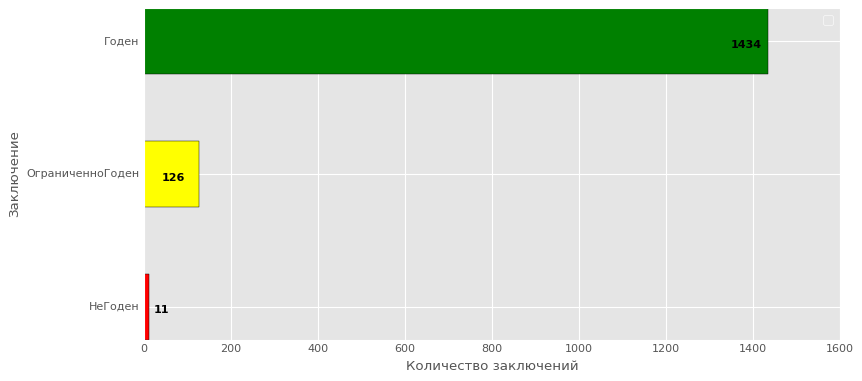

In [ ]:
# Графическое представление:

y_axes = list(df_cor['ЗаключениеМК'].value_counts().index.values)
x_axes = df_cor['ЗаключениеМК'].value_counts().values
colors = ['green', 'yellow', 'r']
plt.figure(figsize = (10, 5))
plt.style.use('ggplot')
plt.barh(y_axes, x_axes, height=0.5, color=colors, edgecolor='black', linewidth=0.4)
for i, v in enumerate(x_axes):
    plt.text(v-85 if v>=90 else v+10, i + 0.05, str(v), color='black', fontweight='bold')
plt.gca().invert_yaxis()
plt.xlabel('Количество заключений')
plt.ylabel('Заключение')
plt.legend()
plt.show()


In [ ]:
#Удалим колонки не имеющие записей
print(f'Размер до - {df_cor.shape}')
df_cor = df_cor.dropna(axis=1, how='all')
print(f'Размер после - {df_cor.shape}')

Размер до - (1571, 4587)
Размер после - (1571, 3578)


In [ ]:
# процет незаполненных ячеек
df_cor.isna().sum().sum() * 100 / df_cor.size

89.01058078368044

In [ ]:
# создадим список колонок датафрейма.
cols_list = df_cor.columns.tolist()
len(cols_list)

3578

In [ ]:
cols_list[:20]

['ДокументПрохождениеМедосмотра',
 'Клиент',
 'КлиентДатаРождения',
 'КлиентПол',
 'КлиентПолПредставление',
 'ДатаЗавершенияМедосмотра',
 'ТипМедосмотра',
 'ТипМедосмотраПредставление',
 'ПсихОсвидетельствование',
 'Контрагент',
 'Цех',
 'Профессия',
 'ЗаключениеМК',
 'ЗаключениеМКПредставление',
 'Заключение',
 'ДиспансернаяГруппа',
 'ДиспансернаяГруппаПредставление',
 'ВредныеФакторы',
 'ЛабораторныеИсследования1_ДокументПрием',
 'ЛабораторныеИсследования1_ДатаПриема']

In [ ]:
info_col('Рентгенология2_Заключение_ЗначениеПредставление', df_cor, True)

Заполнено: 3 ячеек (0.19%), уникальных записей: 1
[nan 'без патологий']
Тип данных:  object


In [ ]:
# Составим список учитываемых колонок
selected_col = ['КлиентДатаРождения','ДатаЗавершенияМедосмотра','КлиентПол','Профессия','ЗаключениеМК','ДиспансернаяГруппа',
           'ВредныеФакторы','Терапия1_П_Значение','Терапия1_ЧССТерапевт_Значение']

In [ ]:
# Добавим некоторые колонки по условию
for elem in cols_list:
    if ('Рекомендация' in elem and 'Представление' in elem) or 'РекомендацияСтр' in elem:       # Добавим колони с рекомендациями
        selected_col.append(elem)
        continue
    if 'МКБ' in elem or 'Детализация' in elem:                  # Колонки с кодами МКБ и Детализация
        selected_col.append(elem)
        continue
    if 'Противопоказание' in elem and 'Представление' in elem:   # Противопоказания
        selected_col.append(elem)
        continue
    if 'Профнепригодность' in elem and 'Представление' in elem:  # Профнепригодность
        selected_col.append(elem)
        continue
    if 'Диагноз' in elem and 'Представление' in elem:            # Диагнозы
        selected_col.append(elem)
        continue
    if 'ГоденНегоден' in elem and 'Представление' in elem:      # ГоденНегоден
        selected_col.append(elem)
        continue
    if 'Анамнез' in elem and 'Представление' in elem:           # Анамнез
        selected_col.append(elem)
        continue
    if 'Аудиометрия' in elem and 'Представление' in elem:       # Аудиометрия
        selected_col.append(elem)
        continue
    if 'Заключение_' in elem and 'Представление' in elem:       # Заключения по специалистам если такие есть.
        selected_col.append(elem)
        continue
# колонки содержащие цировые данные (могут иметь тип не floan и int - преобразовывать будем потом)
    if 'АртериальноеДавление' in elem and 'Представление' in elem:    #
        selected_col.append(elem)
        continue
    if 'Температура' in elem and 'Представление' in elem:          #
        selected_col.append(elem)
        continue
    if 'Сатурация' in elem and 'Представление' in elem:          #
        selected_col.append(elem)
        continue
    if 'ИМТ' in elem and 'Представление' in elem:          #
        selected_col.append(elem)
        continue

print(len(selected_col))
print(selected_col[:5])

481
['КлиентДатаРождения', 'ДатаЗавершенияМедосмотра', 'КлиентПол', 'Профессия', 'ЗаключениеМК']


In [ ]:
# Сократим датафрейм до отобранных колонок.
df_cor = df_cor[selected_col]
df_cor.shape

(1571, 481)

In [ ]:
# Проверка результата: создадим таблицу содержащую данные по заполненности колонки, количеству уникальных значений, и типу данных
counts = df_cor.count(axis=0)
uniques = df_cor.nunique(axis=0)
types = df_cor.dtypes
df_x = pd.concat([counts.to_frame(name='count'), uniques.to_frame(name='unique'), types.to_frame(name='type')], axis= 1 )

In [ ]:
df_x

,count,unique,type
КлиентДатаРождения,1571,1426,object
ДатаЗавершенияМедосмотра,1571,84,object
КлиентПол,1571,2,object
Профессия,1571,557,object
ЗаключениеМК,1571,3,object
...,...,...,...
Оториноларингология3_ПрофнепригодностьВременнаяПредставление1,1,1,object
Оториноларингология3_ГоденНегоден_ЗначениеПредставление,1,1,object
Оториноларингология3_Анамнез_ЗначениеПредставление,1,1,object
Оториноларингология3_Диагноз_ЗначениеПредставление,1,1,object


In [ ]:
# Удалим колонки с одной записью
del_col = list(df_x[(df_x['count'] == 1)].index)
print(len(del_col))
df_cor = df_cor.drop(del_col, axis=1)
df_cor.shape

30


(1571, 451)

In [ ]:
# Визуализируем влияние некоторых колонок на колонку "ЗаключениеМК"
rowses = ['Терапия1_ГоденНегоден_ЗначениеПредставление','Терапия1_П_Значение','Неврология1_ГоденНегоден_ЗначениеПредставление']
viev_row('Терапия1_ГоденНегоден_ЗначениеПредставление','Годен', rowses)

,ЗаключениеМК,Терапия1_ГоденНегоден_ЗначениеПредставление,Терапия1_П_Значение,Неврология1_ГоденНегоден_ЗначениеПредставление
0,Годен,Годен,76.0,NaN
1,Годен,Годен,65.0,Годен
2,ОграниченноГоден,Годен,66.0,NaN
3,Годен,Годен,80.0,Годен
4,ОграниченноГоден,Годен,70.0,Годен
...,...,...,...,...
1961,Годен,Годен,73.0,Годен
1962,Годен,Годен,61.0,Годен
1972,Годен,Годен,90.0,Годен
1973,Годен,Годен,57.0,Годен


In [ ]:
# Выведем колонки заполненные 1 значением
rez_col = list(df_x[(df_x['unique'] == 1)].index)
print(len(rez_col))
print(rez_col)

239
['Рентгенология1_Заключение_ЗначениеПредставление', 'ПсихиатрияНаркология1_ПротивопоказаниеПредставление1', 'Офтальмология1_ГоденНегоден_ЗначениеПредставление', 'Оториноларингология1_ГоденНегоден_ЗначениеПредставление', 'Оториноларингология1_Анамнез_ЗначениеПредставление', 'ХирургНеИсп1_МКБ101', 'ХирургНеИсп1_ДиагнозПредставление1', 'ХирургНеИсп1_ПрофнепригодностьВременнаяПредставление1', 'ХирургНеИсп1_ГоденНегоден_ЗначениеПредставление', 'ХирургНеИсп1_Анамнез_ЗначениеПредставление', 'ХирургНеИсп1_Диагноз_ЗначениеПредставление', 'Стоматология1_ПрофнепригодностьВременнаяПредставление1', 'Стоматология1_ГоденНегоден_ЗначениеПредставление', 'Стоматология1_Анамнез_ЗначениеПредставление', 'Дерматовенерология1_ХР_Рекомендация1Представление', 'Дерматовенерология1_ХР_Рекомендация2Представление', 'Дерматовенерология1_ГоденНегоден_ЗначениеПредставление', 'Дерматовенерология1_Анамнез_ЗначениеПредставление', 'Рентгенология1_МКБ101', 'Рентгенология1_ДиагнозПредставление1', 'Рентгенология1_Профне

In [ ]:
# Сохранение промежуточных результатов фильтрации
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor_1.csv', index=False)

## 2-й этап +
Объединение колонок со сходными данными, приведение цифровых колонок к float64, избавление от явных выбрасов. Заполнение пустых ячеек.

In [ ]:
# Загрузка сохраненных ранее датафреймов
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor_1.csv')

In [ ]:
df_cor.shape

(1571, 451)

In [ ]:
cols_list = df_cor.columns.tolist()
len(cols_list)

451

In [ ]:
selected_col = df_cor.columns.tolist()

In [ ]:
# Чтобы при конкатенции колонок приопитетимели реальные диагнозы очистим ячейки с Z00.0 - отметка о прохождении осмотра(здоров)
# позже заполним этим значение пустые ячейки
df_cor = df_cor.replace(['Z00.0'],np.NaN)

In [ ]:
#Удалим колонки не имеющие записей
print(f'Размер до - {df_cor.shape}')
df_cor = df_cor.dropna(axis=1, how='all')
print(f'Размер после - {df_cor.shape}')

Размер до - (1571, 451)
Размер после - (1571, 420)


In [ ]:
cols_list = df_cor.columns.tolist()
len(cols_list)

420

In [ ]:
sel_mkb = ['ЗаключениеМК']
for i in range(len(cols_list)):
    if 'МКБ' in cols_list[i]:
        sel_mkb.append(cols_list[i])
print(sel_mkb)
display(df_cor[df_cor['ЗаключениеМК'] == 'ОграниченноГоден'][sel_mkb])

['ЗаключениеМК', 'ПсихиатрияНаркология1_МКБ101', 'Офтальмология1_МКБ101', 'Оториноларингология1_МКБ101', 'ХирургНеИсп1_МКБ101', 'Гинекология1_МКБ101', 'Стоматология1_МКБ101', 'Дерматовенерология1_МКБ101', 'Рентгенология1_МКБ101', 'Неврология1_МКБ101', 'Терапия1_МКБ101', 'Хирургия1_МКБ101', 'Офтальмология1_МКБ102', 'Терапия2_МКБ101', 'Неврология2_МКБ101', 'ЛабораторныеИсследования1_МКБ101', 'УЗИДиагностика1_МКБ101', 'УЗИДиагностика2_МКБ101', 'ПсихиатрияНаркология2_МКБ101', 'Терапия1_МКБ102', 'ЛабораторныеИсследования2_МКБ101', 'Терапия1_МКБ103', 'Психиатрия1_МКБ101', 'Гинекология1_МКБ102', 'Рентгенология2_МКБ101', 'Гинекология2_МКБ101', 'Хирургия2_МКБ101', 'ПроцедурнаяМедсестра1_МКБ101', 'ФункциональнаяДиагностика1_МКБ101', 'УЗИДиагностика1_МКБ102', 'Стоматология2_МКБ101', 'Неврология1_МКБ102', 'Оториноларингология2_МКБ101', 'Дерматовенерология1_МКБ102', 'Дерматовенерология2_МКБ101', 'Дерматовенерология2_МКБ102', 'Хирургия1_МКБ102', 'Хирургия2_МКБ102', 'Офтальмология2_МКБ101', 'Офтальмо

,ЗаключениеМК,ПсихиатрияНаркология1_МКБ101,Офтальмология1_МКБ101,Оториноларингология1_МКБ101,ХирургНеИсп1_МКБ101,Гинекология1_МКБ101,Стоматология1_МКБ101,Дерматовенерология1_МКБ101,Рентгенология1_МКБ101,Неврология1_МКБ101,...,ХирургНеИсп2_МКБ102,Психиатрия1_МКБ102,Психиатрия2_МКБ101,Психиатрия2_МКБ102,Рентгенология1_МКБ102,Рентгенология2_МКБ102,Психиатрия3_МКБ101,Психиатрия3_МКБ102,Психиатрия4_МКБ101,Психиатрия4_МКБ102
2,ОграниченноГоден,NaN,H52.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОграниченноГоден,NaN,H52.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ОграниченноГоден,NaN,H52.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,ОграниченноГоден,NaN,H52.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,ОграниченноГоден,NaN,H52.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,ОграниченноГоден,NaN,H52.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1514,ОграниченноГоден,NaN,H52.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529,ОграниченноГоден,NaN,H52.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1552,ОграниченноГоден,NaN,H52.2,H91.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Сохранение промежуточных результатов фильтрации
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor_11.csv', index=False)

In [ ]:
# Загрузка сохраненных ранее датафреймов
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor_11.csv')

In [ ]:
# Объединение родственных колонок по специалистам, используя написанную вначале процедуру col_concat()
# с последующим удалением использованных колонок.
lst_par1 = ['Терап','Хирург','Гинеколог','Стоматолог','Дермато','Психиатр','Невролог','Офтальмолог','Оториноларинголог',
            'Рентгенолог','УЗИ','Лаборатор','Процедур','Эндоскоп','Функционал']
lst_par2 = ['Рекомендация','МКБ','ИМТ','Детализация','Профнепригодность','ГоденНегоден','Диагноз','Анамнез','Аудиометрия',
            'АртериальноеДавление_','Температура','Сатурация','АртериальноеДавление21']
df_cor = df_row_concat(df_cor, lst_par1, lst_par2)
#for elm1 in lst_par1:
#    cols1_list = df_cor.columns.tolist()  # Пересоздаем список колонок чтобы исключить удаленные
#    tst_list = []
#    for elm in cols1_list:
#        if elm1 in elm:
#            tst_list.append(elm)
#    for elm2 in lst_par2:
#        conc_list = []
#        for elm in tst_list:
#            if elm2 in elm:
#                conc_list.append(elm)
#        if len(conc_list) > 1:
#            row_con = conc_list.pop(0)
#            col_concat(row_con, conc_list)
#            df_cor = df_cor.drop(conc_list, axis=1)

print(df_cor.shape)

объединение колонки Терапия1_ХР_Рекомендация1Представление с колонками ['Терапия1_ХР_Рекомендация2Представление', 'Терапия2_ХР_Рекомендация1Представление', 'Терапия2_ХР_Рекомендация2Представление', 'Терапия3_ХР_Рекомендация1Представление', 'Терапия3_ХР_Рекомендация2Представление', 'Терапия4_ХР_Рекомендация1Представление', 'Терапия4_ХР_Рекомендация2Представление']
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия1_ХР_Рекомендация2Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия2_ХР_Рекомендация1Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия2_ХР_Рекомендация2Представление стало - 185
Терапия1_ХР_Рекомендация1Представление было заполнено - 185
Терапия1_ХР_Рекомендация1Представление + Терапия3_ХР_Рекомендация1Представление стало - 185
Терапия1_ХР_Рекомендация1П

In [ ]:
# процет незаполненных ячеек
df_cor.isna().sum().sum() * 100 / df_cor.size

64.88652749451148

In [ ]:
cols_list = df_cor.columns.tolist()
selected_col = []
for elem in cols_list:
    if 'Сатурация' in elem:
        selected_col.append(elem)
counts = df_cor[selected_col].count(axis=0)
uniques = df_cor[selected_col].nunique(axis=0)
types = df_cor[selected_col].dtypes
df_y = pd.concat([counts.to_frame(name='count'), uniques.to_frame(name='unique'), types.to_frame(name='type')], axis= 1 )
df_y

,count,unique,type
Терапия1_Сатурация_ЗначениеПредставление,1183,9,float64


In [ ]:
info_col('Терапия1_Сатурация_ЗначениеПредставление', df_cor, True)

Заполнено: 1183 ячеек (75.3%), уникальных записей: 9
[  nan  97.   98.   99.   36.6  96.   95.  100.   68.   94. ]
Тип данных:  float64


In [ ]:
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor_2.csv', index=False)

In [ ]:
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor_2.csv')

In [ ]:
cols_list = df_cor.columns.tolist()
print(cols_list[:10])
df_cor.head()

['КлиентДатаРождения', 'ДатаЗавершенияМедосмотра', 'КлиентПол', 'Профессия', 'ЗаключениеМК', 'ДиспансернаяГруппа', 'ВредныеФакторы', 'Терапия1_П_Значение', 'Терапия1_ЧССТерапевт_Значение', 'Рентгенология1_Заключение_ЗначениеПредставление']


,КлиентДатаРождения,ДатаЗавершенияМедосмотра,КлиентПол,Профессия,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Терапия1_П_Значение,Терапия1_ЧССТерапевт_Значение,Рентгенология1_Заключение_ЗначениеПредставление,...,Рентгенология2_Заключение_ЗначениеПредставление,ПроцедурнаяМедсестра1_МКБ101,ПроцедурнаяМедсестра1_ДиагнозПредставление1,ПроцедурнаяМедсестра1_ПрофнепригодностьВременнаяПредставление1,ФункциональнаяДиагностика1_МКБ101,ФункциональнаяДиагностика1_ДиагнозПредставление1,ФункциональнаяДиагностика1_ПрофнепригодностьВременнаяПредставление1,Эндоскопия1_МКБ101,Эндоскопия1_ДиагнозПредставление1,Эндоскопия1_ПрофнепригодностьВременнаяПредставление1
0,1976-10-24,2022-01-25,Женский,Ведущий специалист по организации обуения,Годен,I,11.4,76.0,NaN,без патологий,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-11-18,2022-02-02,Мужской,Ведущий специалист,Годен,IIIа,4.2.5,65.0,NaN,без патологий,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985-09-08,2022-02-15,Мужской,Главный менеджер,ОграниченноГоден,II,4.2.5,66.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-04-25,2022-02-16,Мужской,Главный специалист,Годен,I,11.1,80.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1984-04-17,2022-02-22,Мужской,Старший специалист,ОграниченноГоден,II,11.1,70.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Вычисление возраста и переведение его в категориальный тип.
data1 = df_cor['ДатаЗавершенияМедосмотра'].tolist()
data2 = df_cor['КлиентДатаРождения'].tolist()
age = []
for i in range(len(data1)):
    age.append((int(re.search('\d{4}',data1[i])[0]) - int(re.search('\d{4}',data2[i])[0])-12)//7)

df_cor.insert(1,'AGE',age)
df_cor = df_cor.drop(['ДатаЗавершенияМедосмотра','КлиентДатаРождения'], axis=1)
df_cor.head()


,AGE,КлиентПол,Профессия,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Терапия1_П_Значение,Терапия1_ЧССТерапевт_Значение,Рентгенология1_Заключение_ЗначениеПредставление,ПсихиатрияНаркология1_ХР_Рекомендация1Представление,...,Рентгенология2_Заключение_ЗначениеПредставление,ПроцедурнаяМедсестра1_МКБ101,ПроцедурнаяМедсестра1_ДиагнозПредставление1,ПроцедурнаяМедсестра1_ПрофнепригодностьВременнаяПредставление1,ФункциональнаяДиагностика1_МКБ101,ФункциональнаяДиагностика1_ДиагнозПредставление1,ФункциональнаяДиагностика1_ПрофнепригодностьВременнаяПредставление1,Эндоскопия1_МКБ101,Эндоскопия1_ДиагнозПредставление1,Эндоскопия1_ПрофнепригодностьВременнаяПредставление1
0,4,Женский,Ведущий специалист по организации обуения,Годен,I,11.4,76.0,NaN,без патологий,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,Мужской,Ведущий специалист,Годен,IIIа,4.2.5,65.0,NaN,без патологий,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Мужской,Главный менеджер,ОграниченноГоден,II,4.2.5,66.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Мужской,Главный специалист,Годен,I,11.1,80.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Мужской,Старший специалист,ОграниченноГоден,II,11.1,70.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Приведем в порядок цифровые колонки
map_x = lambda x: x if len(str(x)) <= 3 else str(x)[:3]
df_cor['Терапия1_АртериальноеДавление_ЗначениеПредставление'] = df_cor['Терапия1_АртериальноеДавление_ЗначениеПредставление'].map(map_x)
df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'] = df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'].map(map_x)
# И переведем её в float формат
df_cor = df_cor.astype({'Терапия1_АртериальноеДавление_ЗначениеПредставление': np.float64})
df_cor = df_cor.astype({'Терапия1_АртериальноеДавление21_ЗначениеПредставление': np.float64})
df_cor.loc[df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'] > 300,['Терапия1_АртериальноеДавление21_ЗначениеПредставление']] = df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление']/10
map_y = lambda x: str(x).replace(',','.').replace('/','.').replace('..','.')
df_cor['Терапия1_Температура_ЗначениеПредставление'] = df_cor['Терапия1_Температура_ЗначениеПредставление'].map(map_y)
df_cor = df_cor.astype({'Терапия1_Температура_ЗначениеПредставление': np.float64})
df_cor = df_cor.astype({'Терапия1_Сатурация_ЗначениеПредставление': np.float64})
df_cor['Терапия1_ИМТ_ЗначениеПредставление'] = df_cor['Терапия1_ИМТ_ЗначениеПредставление'].map(map_y)
df_cor = df_cor.astype({'Терапия1_ИМТ_ЗначениеПредставление': np.float64})
print(df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'].unique())
print(df_cor['Терапия1_АртериальноеДавление_ЗначениеПредставление'].unique())
print(df_cor['Терапия1_Температура_ЗначениеПредставление'].unique())

[  nan  82.   80.   60.   70.   90.  110.  120.   75.   85.   84.   77.
  72.   68.   78.   83.   64.   76.   74.   86.   89.   87.   71.   88.
 112.   92.   66.  100.   62.   81.   80.1  99.   91.   97.  111.  104.
 102.   95.   98.   69.   96.  105.   73.  108.   63.  101.   93.   79.
  67.  107.  106.   94.  103.  109.   80.5  65.   61.   20.   58.   40.
  59. ]
[140. 150. 120. 110. 105. 130. 125. 133. 100. 160.  nan 180. 115.  90.
 135. 128. 138. 112. 129. 118. 155. 102. 144. 107. 141. 182. 145. 131.
 123. 193. 121. 127. 113. 132. 109. 117. 137. 124. 116. 171. 151. 142.
 134. 146. 168. 119. 111. 177. 165. 122. 153. 159. 143. 147. 148. 167.
 136. 139. 189. 166. 162. 158. 172. 169. 152. 126. 198. 161. 174. 175.
 186. 108. 106. 170. 154. 149. 173. 157. 114. 163.  95. 101.]
[36.4 36.5 36.6 36.3 36.2  nan]


In [ ]:
info_col('AGE', df_cor, False)

Заполнено: 1571 ячеек (100.0%), уникальных записей: 9
3    345
4    294
2    265
5    225
6    211
1    146
7     79
8      4
0      2
Name: AGE, dtype: int64
Тип данных:  int64


In [ ]:
col_concat(df_cor,'Терапия1_П_Значение', ['Терапия1_ЧССТерапевт_Значение'])

Терапия1_П_Значение было заполнено - 1380
Терапия1_П_Значение + Терапия1_ЧССТерапевт_Значение стало - 1380


In [ ]:
df_cor = df_cor.drop(['Терапия1_ЧССТерапевт_Значение'], axis=1)

In [ ]:
# Проверка результата пересоберем df_x
counts = df_cor.count(axis=0)
uniques = df_cor.nunique(axis=0)
types = df_cor.dtypes
df_x = pd.concat([counts.to_frame(name='count'), uniques.to_frame(name='unique'), types.to_frame(name='type')], axis= 1 )

In [ ]:
df_x

,count,unique,type
AGE,1571,9,int64
КлиентПол,1571,2,object
Профессия,1571,557,object
ЗаключениеМК,1571,3,object
ДиспансернаяГруппа,1562,4,object
...,...,...,...
ФункциональнаяДиагностика1_ДиагнозПредставление1,6,1,object
ФункциональнаяДиагностика1_ПрофнепригодностьВременнаяПредставление1,6,1,object
Эндоскопия1_МКБ101,1,1,object
Эндоскопия1_ДиагнозПредставление1,4,2,object


In [ ]:
# Дозаполним пустые ячейки (числовые ячейки заполняем нулями, для МКБ - Z00.0('Медосмотр'), текстовые данные и данные ОНЕ -  )

cols_list = df_cor.columns.tolist()
mkb_col = []
for elem in cols_list:
    if 'МКБ' in elem:
        mkb_col.append(elem)                                                   # Все колонки МКБ
df_cor[mkb_col] = df_cor[mkb_col].fillna('Z00.0')

dig_col = df_cor.select_dtypes(include=['float64','int64']).columns.to_list()
print(len(dig_col))

df_cor[dig_col] = df_cor[dig_col].fillna(0)

df_cor = df_cor.fillna('НетДанных')                                            # Все остальные колонки

8


In [ ]:
# процет незаполненных ячеек
df_cor.isna().sum().sum() * 100 / df_cor.size

0.0

In [ ]:
df_cor.to_csv('/content/drive/MyDrive/profpatolog/df_cor_3.csv', index=False)

## Балансировка, формирование словарей токенайзеров

In [ ]:
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor_3.csv')

In [ ]:
df_cor.shape

(1571, 96)

In [ ]:
cols_list = df_cor.columns.tolist()
len(cols_list)

96

In [ ]:
# Проверим балансировку датасета (соотношение Годен/НеГоден):
rat = len(df_cor.loc[df_cor['ЗаключениеМК']=='Годен'])//len(df_cor.loc[df_cor['ЗаключениеМК']=='НеГоден'])
print(f'Соотношение заключений Годен к НеГоден - {rat} к 1')

# Проверим балансировку датасета (соотношение Годен/ОграниченноГоден):
rat1 = len(df_cor.loc[df_cor['ЗаключениеМК']=='Годен'])//len(df_cor.loc[df_cor['ЗаключениеМК']=='ОграниченноГоден'])
print(f'Соотношение заключений Годен к ОграниченноГоден - {rat1} к 1')

Соотношение заключений Годен к НеГоден - 130 к 1
Соотношение заключений Годен к ОграниченноГоден - 11 к 1


In [ ]:
# Попробуем изменить соотношение размножив минорный класс и перемешав датасет
df_cor = balance_data(df_cor,'ЗаключениеМК','НеГоден','Годен',koef=0.25)
df_cor = balance_data(df_cor,'ЗаключениеМК','ОграниченноГоден','Годен',koef=0.25)
print(df_cor.shape)


Было - (1571, 96)
Стало - (1923, 96)
Было - (1923, 96)
Стало - (2175, 96)
(2175, 96)


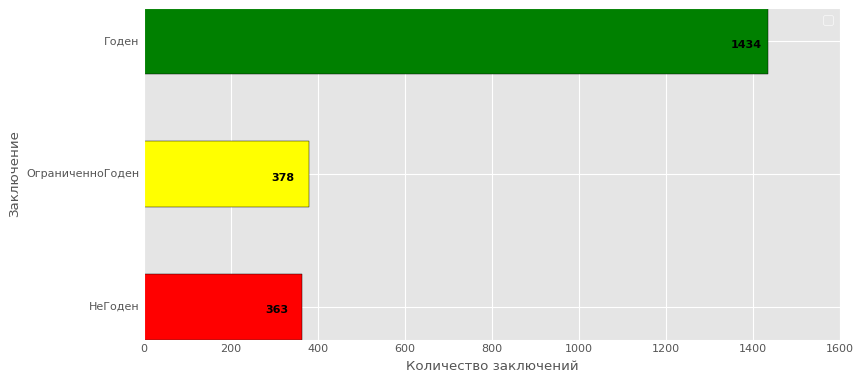

In [ ]:
# Графическое представление:

y_axes = list(df_cor['ЗаключениеМК'].value_counts().index.values)
x_axes = df_cor['ЗаключениеМК'].value_counts().values
colors = ['green', 'yellow', 'r']
plt.figure(figsize = (10, 5))
plt.style.use('ggplot')
plt.barh(y_axes, x_axes, height=0.5, color=colors, edgecolor='black', linewidth=0.4)
for i, v in enumerate(x_axes):
    plt.text(v-85 if v>=90 else v+10, i + 0.05, str(v), color='black', fontweight='bold')
plt.gca().invert_yaxis()
plt.xlabel('Количество заключений')
plt.ylabel('Заключение')
plt.legend()
plt.show()


In [ ]:
info_col('ВредныеФакторы', df_cor)

Заполнено: 2175 ячеек (100.0%), уникальных записей: 388
23                                     180
4.2.5                                  134
4.1,6.2,18.1,18.2,4.1,6.2,18.1,18.2     68
11.1                                    50
9                                       46
                                      ... 
3.1.2,4.8,15                             1
4.4,11.1,9                               1
1.50,4.3.1,4.3.2,11.1,18                 1
4.4,5.1,6,11.1                           1
11.1,4.4,6,5.1                           1
Name: ВредныеФакторы, Length: 388, dtype: int64
Тип данных:  object


In [ ]:
# Оценка колонки "Профессия"
info_col('Профессия', df_cor)

Заполнено: 2175 ячеек (100.0%), уникальных записей: 557
Водитель автомобиля                                      154
Ведущий агроном                                           52
Ведущий специалист                                        48
Старший специалист                                        42
Переработчик РАО                                          41
                                                        ... 
Гардеробщик                                                1
Машинист автокрана автомобильного                          1
Врач-стоматолог-ортопед                                    1
Врач стоматолог - ортопед                                  1
управление наземными транспортными средствами (кат В)      1
Name: Профессия, Length: 557, dtype: int64
Тип данных:  object


In [ ]:
# Проведем колонку "Профессия" через токенайзер отбросим числа, чтобы не учитывать разряды и номера категорий, а только сами специальности.
words_prof = 508
tokenizer_spec = Tokenizer(num_words=words_prof, filters='i1234567890!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_spec.fit_on_texts(df_cor['Профессия'].tolist())
max(tokenizer_spec.word_index.values())

508

In [ ]:
# Колонка "ВредныеФакторы" из фильтра исключим ".", чтобы индексы сохранились правильно
words_bed = 92
tokenizer_bed = Tokenizer(num_words=words_bed, filters='i!"#$%&()*+,-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='0.0.0', char_level=False)
tokenizer_bed.fit_on_texts(list(df_cor['ВредныеФакторы']))
print(max(tokenizer_bed.word_index.values()))
print(tokenizer_bed.word_counts)

92
OrderedDict([('11.1', 419), ('4.2.5', 386), ('4.1', 307), ('6.1', 545), ('1.29.2', 65), ('4.4', 525), ('4.7', 107), ('6.2', 386), ('23', 236), ('1.14.2', 109), ('1.23', 39), ('3.1.7', 69), ('1.1', 135), ('1.8.1.1', 62), ('1.34.1', 66), ('1.50', 292), ('3.4', 20), ('5.1', 395), ('4.8', 62), ('6', 118), ('9', 307), ('18.1', 507), ('4.3.2', 216), ('8', 23), ('11.3', 99), ('11.4', 162), ('18.2', 355), ('1.30.1', 116), ('3.1.8.1', 14), ('25', 93), ('15', 183), ('1.8.1.2', 24), ('1.18.3', 17), ('1.19.1', 30), ('1.29.1', 28), ('1.36.1', 46), ('1.37.1', 71), ('1.39', 52), ('17', 41), ('4.3.1', 114), ('4.9', 13), ('18', 65), ('1.3', 23), ('3.1.8.3', 12), ('11', 45), ('1.49', 9), ('27', 48), ('5.2', 2), ('1.29.4', 15), ('4.5', 37), ('1.48', 11), ('22', 33), ('1.15', 6), ('3.1.8.2', 11), ('1.8.2.1', 17), ('1.37.1.1', 10), ('1.49.2', 1), ('12', 33), ('1.2', 4), ('1.37', 4), ('4.6', 14), ('3.1.2', 15), ('1.14.1', 4), ('13', 24), ('14', 3), ('10', 2), ('4.2.3', 10), ('4.2.1', 17), ('1.8.2.2', 7),

In [ ]:
# Рассортируем колони по типу обработки
dig_col = df_cor.select_dtypes(include=['float64','int64']).columns.to_list()
if 'AGE' in dig_col:
    dig_col.remove('AGE')
ohe_col = ['КлиентПол','ДиспансернаяГруппа','AGE']
ozer_col = ['КлиентДатаРождения','ДатаЗавершенияМедосмотра','ЗаключениеМК','Профессия','ВредныеФакторы']
txt_col = []
for elem in cols_list:
    if 'Профнепригодность' in elem or 'ГоденНегоден' in elem or 'МКБ' in elem:
        ohe_col.append(elem)
        continue
    elif elem not in (ozer_col + ohe_col + dig_col):
        txt_col.append(elem)

print(f'OHE - {len(ohe_col)}, Текстовая инф.(Заключения и диагнозы) - {len(txt_col)}, числовые данные {len(dig_col)}')

OHE - 42, Текстовая инф.(Заключения и диагнозы) - 44, числовые данные 7


In [ ]:
dig_col

['Терапия1_П_Значение',
 'Терапия1_Температура_ЗначениеПредставление',
 'Терапия1_АртериальноеДавление_ЗначениеПредставление',
 'ФункциональнаяДиагностика1_ТемператураТела_ЗначениеПредставление',
 'Терапия1_Сатурация_ЗначениеПредставление',
 'Терапия1_ИМТ_ЗначениеПредставление',
 'Терапия1_АртериальноеДавление21_ЗначениеПредставление']

In [ ]:
# Сборка данных из строковых колонок в одну строку, с посл оценкой максимальной и минимальной длины строки
list_diag = list(df_cor[txt_col].values.tolist())
lst_diag = []
lens = np.zeros(len(list_diag), dtype=int)
for i in range(len(list_diag)):
    lst_diag.append(' '.join(list_diag[i]))
    lens[i] = len(lst_diag[i])
print(len(lst_diag))
print('Пример одной из строк:',lst_diag[5],sep='\n')
print('Длина строки:',len(lst_diag[5]),sep='\n')
print(f'max - {max(lens)}, min - {min(lens)}')

2175
Пример одной из строк:
НетДанных НетДанных Общий медицинский осмотр не отягощен Наблюдение офтальмолога по мж Миопия Миопия слабой степени не отягощен Общий медицинский осмотр НетДанных не отягощен не подлежит обследованию НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных Общий медицинский осмотр НетДанных не отягощен НетДанных НетДанных Общий медицинский осмотр НетДанных не отягощен Общий медицинский осмотр НетДанных НетДанных НетДанных НетДанных НетДанных Общий медицинский осмотр НетДанных НетДанных НетДанных НетДанных НетДанных
Длина строки:
583
max - 1218, min - 439


In [ ]:
words_num = 871
tokenizer_diag = Tokenizer(num_words=words_num, filters='i1234567890!xdjzhglnf№"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_diag.fit_on_texts(lst_diag)
items = list(tokenizer_diag.word_index.items())
max(tokenizer_diag.word_index.values())

871

## формирование Dataseta создание модели

In [ ]:
# Собственно само преобразование колонок OHE с сохранением LabelEncoder() для каждой колонки
x_data1, list_code, list_encode = df_to_ohe(df_cor,ohe_col)
print(x_data1.shape)
print(x_data1[7])
print(len(list_encode))
print(list_encode)

(2175, 175)
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1.]
42
{'КлиентПол': LabelEncoder(), 'ДиспансернаяГруппа': LabelEncoder(), 'AGE': LabelEncoder(), 'ПсихиатрияНаркология1_МКБ101': LabelEncoder(), 'ПсихиатрияНаркология1_ПрофнепригодностьВременнаяПредставление1': LabelEncoder(), 'ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление': LabelEncoder(), 'Офтальмология1_МКБ101': LabelEncoder(), 'Офтальмология1_ПрофнепригодностьВременнаяПредставление1': LabelEncoder(), 'Офтальмология1_ГоденНегоден_ЗначениеП

In [ ]:
# Проверим результат:
print(list_encode['ПсихиатрияНаркология1_МКБ101'].classes_)
print(list_encode['КлиентПол'].classes_)

['F06.6' 'F06.7' 'F07.0' 'F41.0' 'F98.5' 'R25.1' 'Z00.0']
['Женский' 'Мужской']


In [ ]:
# Отдельно преобразуем целевую колонку
y_data, y_code, y_encode = df_to_ohe(df_cor,['ЗаключениеМК'])
print(y_data.shape)
print(y_data[7])
print(y_encode['ЗаключениеМК'].classes_)

(2175, 3)
[1. 0. 0.]
['Годен' 'НеГоден' 'ОграниченноГоден']


In [ ]:
y_sum = y_data.sum(axis=0)

In [ ]:
# Заполним список категорий после энкодинга
row_y = df_cor['ЗаключениеМК'].value_counts()
kat = []
for i in range(len(row_y)):
    kat.append(row_y[row_y == y_sum[i]].index.values[0])

print(kat)

['Годен', 'НеГоден', 'ОграниченноГоден']


In [ ]:
# Получение BagOfWords по колонкам "Профессия", "ВредныеФакторы", и все текстовые колонки
bow_spec = tokenizer_spec.texts_to_matrix(df_cor['Профессия'].tolist())
bow_bed = tokenizer_bed.texts_to_matrix(df_cor['ВредныеФакторы'].tolist())
bow_diag = tokenizer_diag.texts_to_matrix(lst_diag)
print(bow_spec.shape, bow_bed.shape, bow_diag.shape, sep='\n')

(2175, 508)
(2175, 92)
(2175, 871)


In [ ]:
# Соберём все BOW в один масив
x_data2 = np.hstack([bow_spec, bow_bed, bow_diag])
x_data2.shape

(2175, 1471)

In [ ]:
# Числовые данные - в отдельный масив
x_data3 = np.array(df_cor[dig_col].values)
print(x_data3.shape)
print(x_data3[10:20])
print(x_data3.max())

(2175, 7)
[[ 68.     0.   110.    36.6    0.     0.    68.  ]
 [ 65.     0.   120.    36.6   98.    27.76  70.  ]
 [  0.     0.     0.     0.     0.     0.     0.  ]
 [ 65.     0.   120.    36.6   98.    17.92  80.  ]
 [ 66.     0.   110.    36.6   99.    23.05  65.  ]
 [ 69.     0.   110.    36.6    0.    29.3   70.  ]
 [ 71.     0.   189.     0.    95.    34.2  112.  ]
 [ 75.     0.   108.     0.    97.    26.3   70.  ]
 [ 80.     0.   120.    36.6    0.    18.79  80.  ]
 [ 74.     0.   130.    36.6    0.    32.46  80.  ]]
198.0


In [ ]:
# Нормализация числовых данных
x_data3 = x_data3 / x_data3.max()
print(x_data3[10:20])
print(x_data3.max())

[[0.34343434 0.         0.55555556 0.18484848 0.         0.
  0.34343434]
 [0.32828283 0.         0.60606061 0.18484848 0.49494949 0.14020202
  0.35353535]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.32828283 0.         0.60606061 0.18484848 0.49494949 0.09050505
  0.4040404 ]
 [0.33333333 0.         0.55555556 0.18484848 0.5        0.11641414
  0.32828283]
 [0.34848485 0.         0.55555556 0.18484848 0.         0.1479798
  0.35353535]
 [0.35858586 0.         0.95454545 0.         0.47979798 0.17272727
  0.56565657]
 [0.37878788 0.         0.54545455 0.         0.48989899 0.13282828
  0.35353535]
 [0.4040404  0.         0.60606061 0.18484848 0.         0.09489899
  0.4040404 ]
 [0.37373737 0.         0.65656566 0.18484848 0.         0.16393939
  0.4040404 ]]
1.0


In [ ]:
# Получим из словарь частотности для embedding слоя
x_seq4 = tokenizer_diag.texts_to_sequences(lst_diag)

In [ ]:
# проверка того что получилось на сл. строке
n = 131
print(lst_diag[n])
print(len(lst_diag[n]))
print(x_seq4[n])
print(len(x_seq4[n]))

НетДанных НетДанных Общий медицинский осмотр не отягощен Наблюдение офтальмолога по мж Гиперметропия гиперметропия слаб.ст не отягощен Общий медицинский осмотр НетДанных не отягощен НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных НетДанных Общий медицинский осмотр НетДанных не отягощен НетДанных НетДанных Общий медицинский осмотр НетДанных не отягощен Общий медицинский осмотр НетДанных Без особенностей Пупочная грыжа. Без особенностей НетДанных НетДанных Общий медицинский осмотр НетДанных НетДанных НетДанных НетДанных
595
[2, 2, 4, 5, 3, 6, 7, 35, 60, 26, 50, 30, 30, 128, 11, 6, 7, 4, 5, 3, 2, 6, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 5, 3, 2, 6, 7, 2, 2, 4, 5, 3, 2, 6, 7, 4, 5, 3, 2, 8, 72, 148, 125, 8, 72, 2, 2, 4, 5, 3, 2, 2, 2, 2]
69


In [ ]:
# Создаем массив (размерностью кол-во строк) х (макс длина emdedding последовательности) заполняем её 0
lens = np.zeros(len(x_seq4), dtype=int)
for i in range(len(x_seq4)):
    lens[i] = len(x_seq4[i])

print(f'max - {max(lens)}, min - {min(lens)}')
x_data4 = np.zeros((len(x_seq4),max(lens)))

# Зальем в него Embedding поледовательности получится 1 вектор для каждой записи
for i in range(len(x_seq4)):
    for j in range(len(x_seq4[i])):
        x_data4[i,j] = x_seq4[i][j]
print(x_data4.shape)
print(x_data4[12])

max - 141, min - 44
(2175, 141)
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Сохраним данный для работы с обученной моделью вне ноутбука.
# они необходимы для фильтрации и подготовки данных перед передачей модели для получения результата
with open('/content/drive/MyDrive/profpatolog/datas.pkl', "wb") as f: # Открывем файл в формате чтение и запись
    pkl.dump([selected_col,tokenizer_spec,tokenizer_bed,tokenizer_diag,list_encode,y_encode,dig_col,ohe_col,txt_col], f)           # Записываем сериализованные объекты

In [ ]:
mycolback = ModelCheckpoint('/content/drive/MyDrive/profpatolog/bestarch1.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

In [ ]:
# Создание разветвленной модели
input_x1 = Input(shape=(x_data1.shape[1]), name = 'input_x1')
x1 = Dense(256, activation = 'relu', name = 'Dense1_x1') (input_x1)
x1 = Dropout(0.4, name = 'Dropout1_x1') (x1)
x1 = Dense(128, activation = 'relu', name = 'Dense2_x1') (x1)

input_x2 = Input(shape=(x_data2.shape[1]), name = 'input_x2')
x2 = Dense(1000, activation = 'relu', name = 'Dense1_x2') (input_x2)
x2 = Reshape((1000,1)) (x2)
#x2 = Conv1D(20, 5, activation='relu') (x2)
x2 = Conv1D(10, 5, activation='relu') (x2)
x2 = SpatialDropout1D(0.4) (x2)
x2 = MaxPool1D(4) (x2)
x2 = Flatten() (x2)
x2 = Dropout(0.4, name = 'Dropout1_x2') (x2)
x2 = Dense(64, activation = 'relu', name = 'Dense2_x2') (x2)

input_x3 = Input(shape=(x_data3.shape[1]), name = 'input_x3')
x3 = Dense(64, activation = 'relu', name = 'Dense1_x3') (input_x3)
x3 = Dropout(0.4, name = 'Dropout1_x3') (x3)
x3 = Dense(16, activation = 'relu', name = 'Dense2_x3') (x3)

input_x4 = Input(shape=(x_data4.shape[1]), name = 'input_x4')
x4 = Embedding(input_dim = words_num, output_dim =20, input_length = x_data4.shape[1], name = 'Embedding1_x4') (input_x4)
x4 = SpatialDropout1D(0.4 , name = 'Dropout1_x4') (x4)
x4 = BatchNormalization() (x4)
x4 = Conv1D(20, 5, activation='relu') (x4)
x4 = Conv1D(10, 5, activation='relu') (x4)
x4 = MaxPool1D(2) (x4)
x4 = Flatten(name = 'Flatten1_x4') (x4)
x4 = Dropout(0.4, name = 'Dropout2_x4') (x4)
x4 = Dense(64, activation = 'relu', name = 'Dense1_x4') (x4)

x5 = add([x2, x4])

x = concatenate([x1, x3, x5])

x = Dense(128, activation='relu') (x)

x = Dropout(0.3) (x)

output = Dense(3, activation='softmax', name = 'output') (x)

model = Model ([input_x1, input_x2, input_x3, input_x4], output)


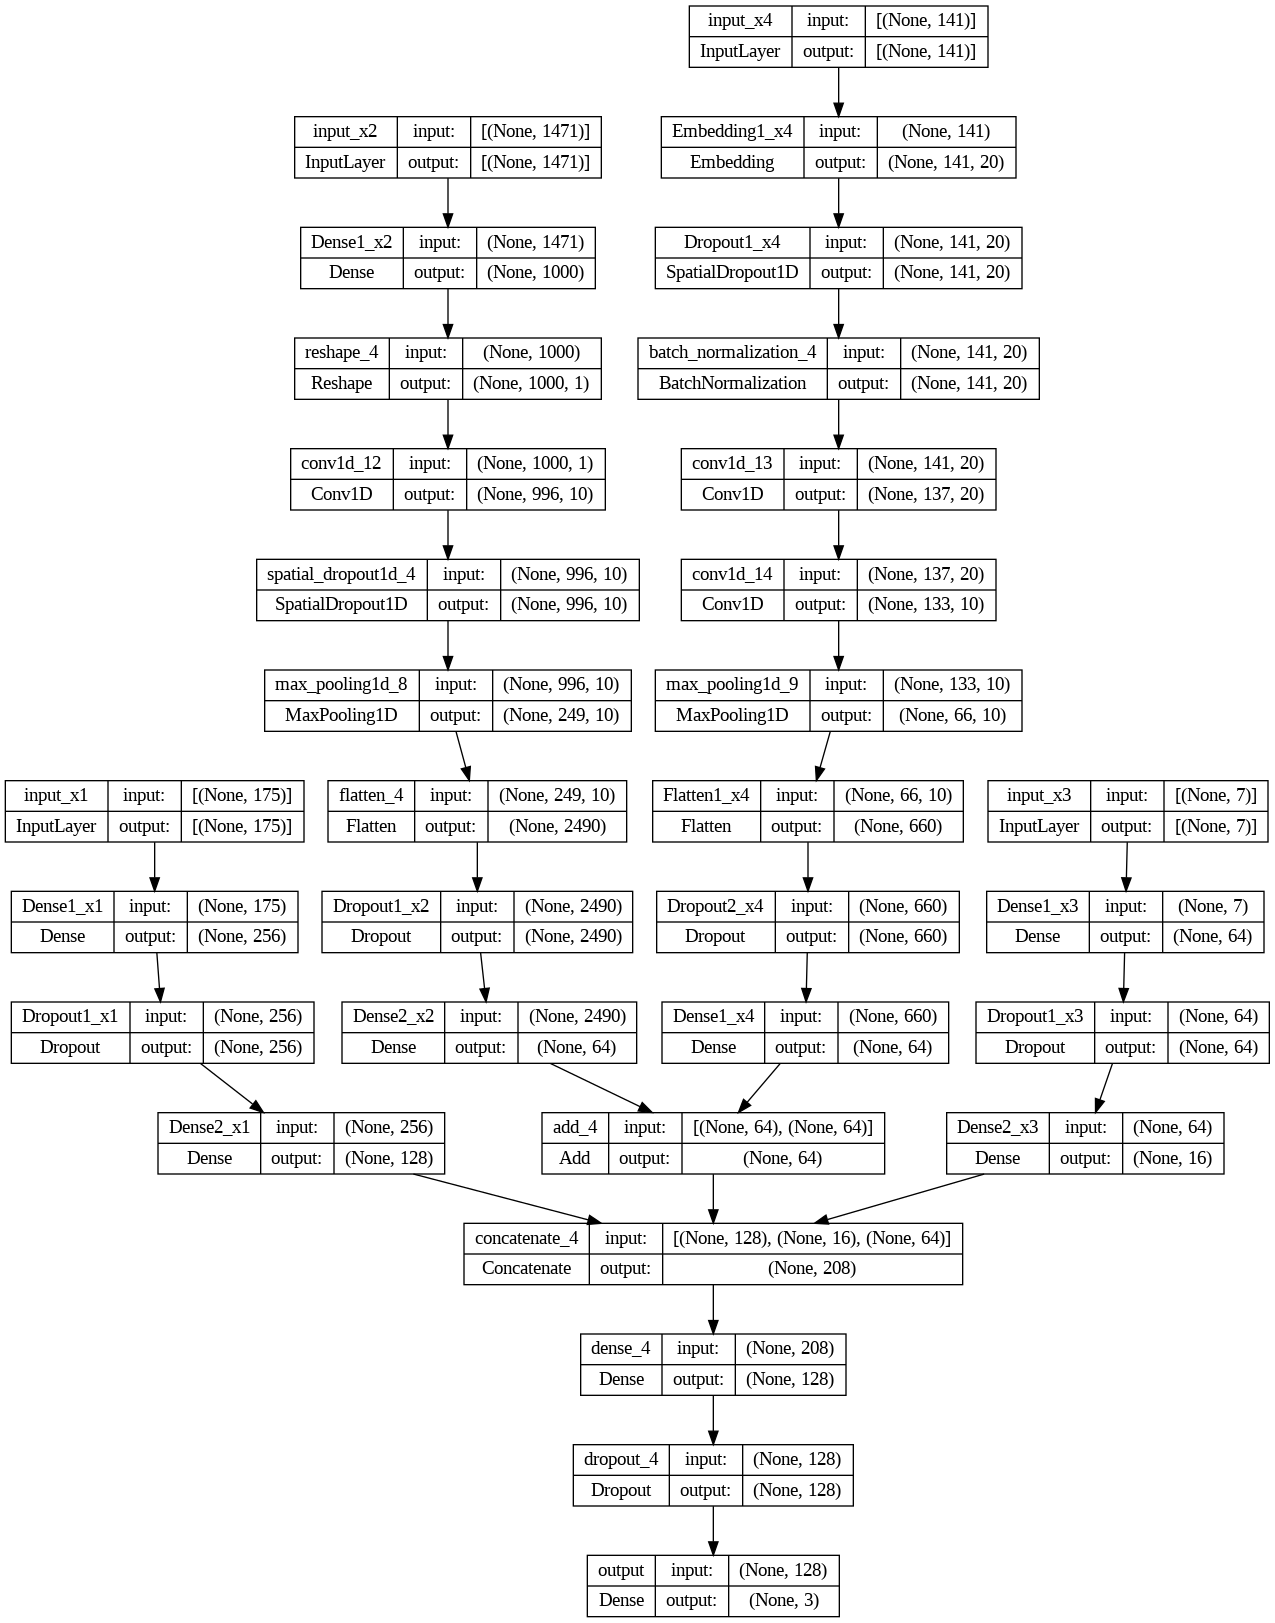

In [ ]:
# Её структура
utils.plot_model(model, show_shapes=True)

In [ ]:
# Компиляция и обучение
#model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[Precision()])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=3),'accuracy'])
history1 = model.fit({'input_x1':x_data1,'input_x2':x_data2,'input_x3':x_data3,'input_x4':x_data4}, y_data, batch_size=64, validation_split=0.2, epochs=40, verbose=1, callbacks=mycolback, shuffle=True)

Epoch 1/40
27/28 [===========================>..] - ETA: 0s - loss: 0.9896 - f1_score: 0.3513 - accuracy: 0.5480
Epoch 1: val_accuracy did not improve from 0.98161
28/28 [==============================] - 6s 92ms/step - loss: 0.9874 - f1_score: 0.3516 - accuracy: 0.5500 - val_loss: 0.8596 - val_f1_score: 0.2678 - val_accuracy: 0.6713
Epoch 2/40
27/28 [===========================>..] - ETA: 0s - loss: 0.8426 - f1_score: 0.3031 - accuracy: 0.6615
Epoch 2: val_accuracy did not improve from 0.98161
28/28 [==============================] - 2s 76ms/step - loss: 0.8428 - f1_score: 0.3047 - accuracy: 0.6615 - val_loss: 0.7849 - val_f1_score: 0.2678 - val_accuracy: 0.6713
Epoch 3/40
27/28 [===========================>..] - ETA: 0s - loss: 0.7487 - f1_score: 0.4260 - accuracy: 0.6973
Epoch 3: val_accuracy did not improve from 0.98161
28/28 [==============================] - 2s 76ms/step - loss: 0.7490 - f1_score: 0.4259 - accuracy: 0.6966 - val_loss: 0.6774 - val_f1_score: 0.4920 - val_accuracy:

In [ ]:
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#history2 = model.fit({'input_x1':x_data1,'input_x2':x_data2,'input_x3':x_data3,'input_x4':x_data4}, y_data, batch_size=32, validation_split=0.15, epochs=20, verbose=1)

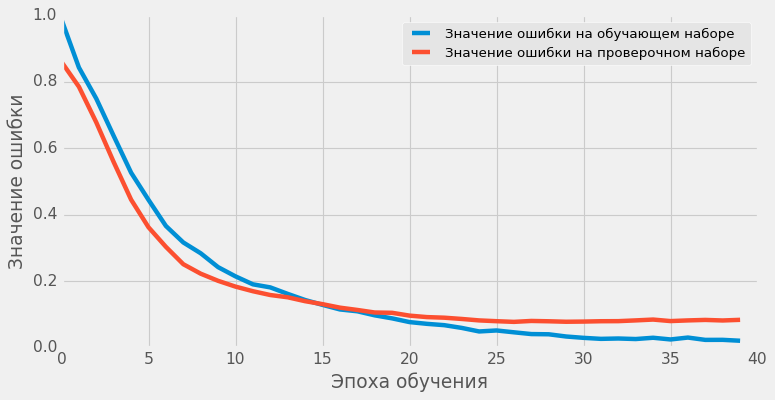

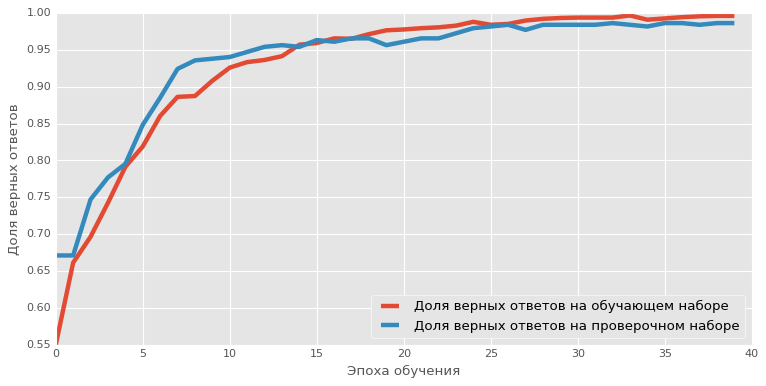

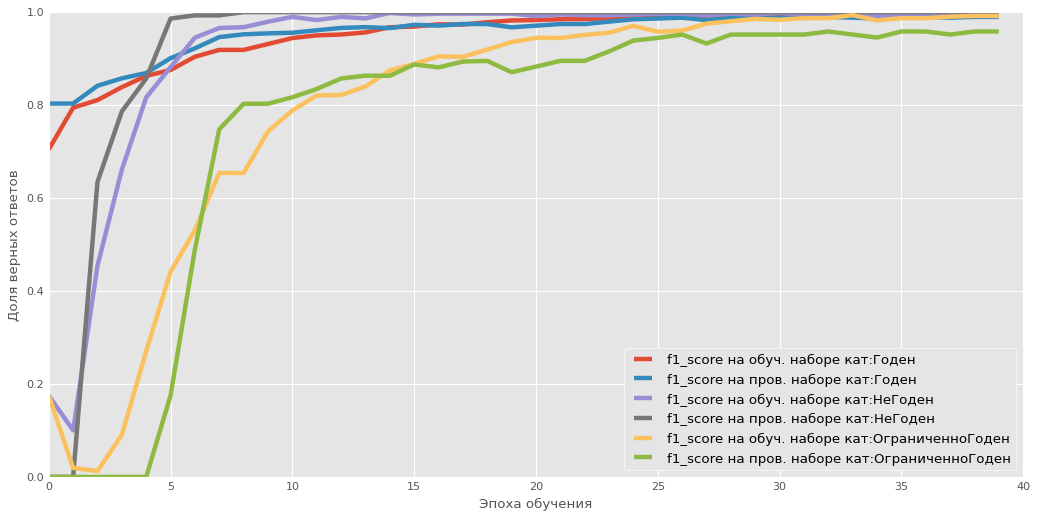

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history1.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history1.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.style.use('ggplot')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения метрика "accuracy"
plt.figure(figsize = (10, 5))
plt.plot(history1.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='lower right')
plt.show()

# Строим график для отображения динамики обучения метрика "F1Score" по каждому классу
plt.figure(figsize = (14, 7))
for i in range(3):
    plt.plot([history1.history['f1_score'][l][i]  for l in range(len(history1.history['f1_score']))],
             label=f'f1_score на обуч. наборе кат:{kat[i]}')
    plt.plot([history1.history['val_f1_score'][l][i]  for l in range(len(history1.history['f1_score']))],
             label=f'f1_score на пров. наборе кат:{kat[i]}')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/profpatolog/bestarch1.h5')

1/1 [==============================] - 1s 527ms/step


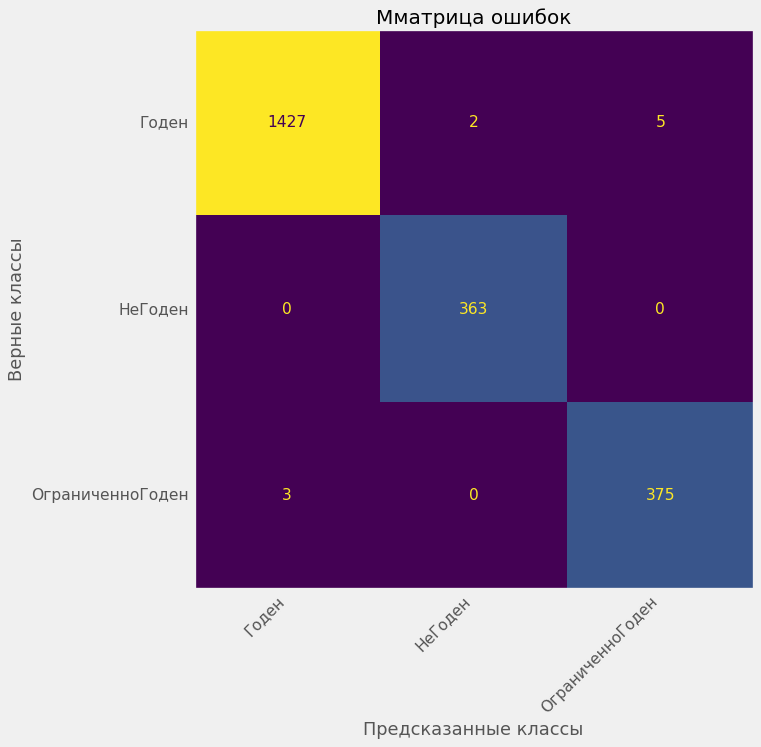

In [ ]:
# Вывод матрицы ошибок предсказания
x = {'input_x1':x_data1,'input_x2':x_data2,'input_x3':x_data3,'input_x4':x_data4}
# Вычисление предсказания сети
y_pred = model.predict(x,batch_size=x_data1.shape[0])
# Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_data, axis=1),
                      np.argmax(y_pred, axis=1))
# Округление значений матрицы ошибок если применена нормализация
#cm = np.around(cm, 2)

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f'Мматрица ошибок', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kat)
disp.plot(ax=ax)
plt.style.use('fivethirtyeight')
plt.grid(None)
plt.gca().images[-1].colorbar.remove()
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)
plt.show()


# Проверка модели и реализация рекомендаций
Рекомендации будут основываться на рекомендациях отдельных специалистов.

In [154]:
# Загрузка обученной модели
model = load_model('/content/drive/MyDrive/profpatolog/bestarch1.h5')
# Восстановление переменных для работы с обученной моделью
with open('/content/drive/MyDrive/profpatolog/datas.pkl', "rb") as f: # Открывем файл в формате чтение и запись
    selected_col,tokenizer_spec,tokenizer_bed,tokenizer_diag,list_encode,y_encode,dig_col,ohe_col,txt_col = pkl.load(f)
# Проверка
print(len(selected_col))

451


In [155]:
# Загрузим датафрейс с "правильной" колонкой "ЗаключениеМК"
df_cor = pd.read_csv('/content/drive/MyDrive/profpatolog/df_cor_1_1.csv')

<ipython-input-155-cb66b93b3517>:2: DtypeWarning: Columns (43,44,45,46,47,48,54,55,56,57,58,59,60,61,62,63,64,65,77,78,81,85,86,87,88,89,90,91,92,109,113,121,123,125,127,162,163,164,168,169,170,171,172,173,195,196,201,202,203,204,205,206,207,208,228,270,271,272,273,282,283,284,285,286,287,293,294,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,324,326,328,330,331,332,334,336,338,340,342,344,346,348,350,351,352,353,354,355,356,363,364,365,366,367,370,393,395,397,399,401,403,405,406,407,419,434,435,436,437,438,439,440,441,442,443,444,445,447,449,451,453,455,457,459,483,484,485,486,491,492,514,515,526,527,528,529,530,531,537,538,539,540,549,550,552,553,554,555,564,565,579,581,585,587,589,591,593,595,597,599,601,603,605,607,609,611,613,615,617,619,621,623,625,627,629,631,634,635,637,644,645,646,647,648,651,652,653,654,655,681,682,693,694,705,708,711,712,786,787,788,800,806,807,808,809,831,832,833,834,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,85

In [156]:
print(df_cor.shape)

(1571, 4587)


In [202]:
# Выберем случайную запись
indx = 182
df_sel = df_cor.iloc[indx:indx+1][selected_col]
#df_sel = df_sel[selected_col]
df_sel

,КлиентДатаРождения,ДатаЗавершенияМедосмотра,КлиентПол,Профессия,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Терапия1_П_Значение,Терапия1_ЧССТерапевт_Значение,Рентгенология1_Заключение_ЗначениеПредставление,...,Психиатрия3_Диагноз_ЗначениеПредставление,Психиатрия4_МКБ101,Психиатрия4_ДиагнозПредставление1,Психиатрия4_ПрофнепригодностьВременнаяПредставление1,Психиатрия4_МКБ102,Психиатрия4_ДиагнозПредставление2,Психиатрия4_ПрофнепригодностьВременнаяПредставление2,Психиатрия4_ГоденНегоден_ЗначениеПредставление,Психиатрия4_Анамнез_ЗначениеПредставление,Психиатрия4_Диагноз_ЗначениеПредставление
182,1986-07-23,2022-10-10,Мужской,Водитель автомобиля 6 разряда,НеГоден,IIIа,"11.1,18.1",80.0,NaN,без патологий,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
df_sel = df_sel.replace(['Z00.0'],np.NaN)

In [204]:
lst_par1 = ['Терап','Хирург','Гинеколог','Стоматолог','Дермато','Психиатр','Невролог','Офтальмолог','Оториноларинголог',
            'Рентгенолог','УЗИ','Лаборатор','Процедур','Эндоскоп','Функционал']
lst_par2 = ['Рекомендация','МКБ','ИМТ','Детализация','Профнепригодность','ГоденНегоден','Диагноз','Анамнез','Аудиометрия',
            'АртериальноеДавление_','Температура','Сатурация','АртериальноеДавление21']
df_sel = df_row_concat(df_sel, lst_par1, lst_par2)

объединение колонки Терапия1_ХР_Рекомендация1Представление с колонками ['Терапия1_ХР_Рекомендация2Представление', 'Терапия2_ХР_Рекомендация1Представление', 'Терапия2_ХР_Рекомендация2Представление', 'Терапия3_ХР_Рекомендация1Представление', 'Терапия3_ХР_Рекомендация2Представление', 'Терапия4_ХР_Рекомендация1Представление', 'Терапия4_ХР_Рекомендация2Представление']
Терапия1_ХР_Рекомендация1Представление было заполнено - 1
Терапия1_ХР_Рекомендация1Представление + Терапия1_ХР_Рекомендация2Представление стало - 1
Терапия1_ХР_Рекомендация1Представление было заполнено - 1
Терапия1_ХР_Рекомендация1Представление + Терапия2_ХР_Рекомендация1Представление стало - 1
Терапия1_ХР_Рекомендация1Представление было заполнено - 1
Терапия1_ХР_Рекомендация1Представление + Терапия2_ХР_Рекомендация2Представление стало - 1
Терапия1_ХР_Рекомендация1Представление было заполнено - 1
Терапия1_ХР_Рекомендация1Представление + Терапия3_ХР_Рекомендация1Представление стало - 1
Терапия1_ХР_Рекомендация1Представление был

In [205]:
df_sel.shape

(1, 98)

In [206]:
#Вычисление возраста и переведение его в категориальный тип.
data1 = df_sel['ДатаЗавершенияМедосмотра'].tolist()
data2 = df_sel['КлиентДатаРождения'].tolist()
age = []
for i in range(len(data1)):
    age.append((int(re.search('\d{4}',data1[i])[0]) - int(re.search('\d{4}',data2[i])[0])-12)//7)

df_sel.insert(1,'AGE',age)
df_sel = df_sel.drop(['ДатаЗавершенияМедосмотра','КлиентДатаРождения'], axis=1)
df_sel.head()

,AGE,КлиентПол,Профессия,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Терапия1_П_Значение,Терапия1_ЧССТерапевт_Значение,Рентгенология1_Заключение_ЗначениеПредставление,ПсихиатрияНаркология1_ХР_Рекомендация1Представление,...,Рентгенология2_Заключение_ЗначениеПредставление,ПроцедурнаяМедсестра1_МКБ101,ПроцедурнаяМедсестра1_ДиагнозПредставление1,ПроцедурнаяМедсестра1_ПрофнепригодностьВременнаяПредставление1,ФункциональнаяДиагностика1_МКБ101,ФункциональнаяДиагностика1_ДиагнозПредставление1,ФункциональнаяДиагностика1_ПрофнепригодностьВременнаяПредставление1,Эндоскопия1_МКБ101,Эндоскопия1_ДиагнозПредставление1,Эндоскопия1_ПрофнепригодностьВременнаяПредставление1
182,3,Мужской,Водитель автомобиля 6 разряда,НеГоден,IIIа,"11.1,18.1",80.0,NaN,без патологий,NaN,...,NaN,NaN,Общий медицинский осмотр,Годен,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
# Приведем в порядок цифровые колонки
map_x = lambda x: x if len(str(x)) <= 3 else str(x)[:3]
df_sel['Терапия1_АртериальноеДавление_ЗначениеПредставление'] = df_sel['Терапия1_АртериальноеДавление_ЗначениеПредставление'].map(map_x)
df_sel['Терапия1_АртериальноеДавление21_ЗначениеПредставление'] = df_sel['Терапия1_АртериальноеДавление21_ЗначениеПредставление'].map(map_x)
# И переведем её в float формат
df_sel = df_sel.astype({'Терапия1_АртериальноеДавление_ЗначениеПредставление': np.float64})
df_sel = df_sel.astype({'Терапия1_АртериальноеДавление21_ЗначениеПредставление': np.float64})
df_sel.loc[df_sel['Терапия1_АртериальноеДавление21_ЗначениеПредставление'] > 300,['Терапия1_АртериальноеДавление21_ЗначениеПредставление']] = df_sel['Терапия1_АртериальноеДавление21_ЗначениеПредставление']/10
map_y = lambda x: str(x).replace(',','.').replace('/','.').replace('..','.')
df_sel['Терапия1_Температура_ЗначениеПредставление'] = df_cor['Терапия1_Температура_ЗначениеПредставление'].map(map_y)
df_sel = df_sel.astype({'Терапия1_Температура_ЗначениеПредставление': np.float64})
df_sel = df_sel.astype({'Терапия1_Сатурация_ЗначениеПредставление': np.float64})
df_sel['Терапия1_ИМТ_ЗначениеПредставление'] = df_cor['Терапия1_ИМТ_ЗначениеПредставление'].map(map_y)
df_sel = df_sel.astype({'Терапия1_ИМТ_ЗначениеПредставление': np.float64})
#print(df_cor['Терапия1_АртериальноеДавление21_ЗначениеПредставление'].unique())
#print(df_cor['Терапия1_АртериальноеДавление_ЗначениеПредставление'].unique())
#print(df_cor['Терапия1_Температура_ЗначениеПредставление'].unique())

In [208]:
col_concat(df_sel,'Терапия1_П_Значение', ['Терапия1_ЧССТерапевт_Значение'])
df_sel = df_sel.drop(['Терапия1_ЧССТерапевт_Значение'], axis=1)

Терапия1_П_Значение было заполнено - 1
Терапия1_П_Значение + Терапия1_ЧССТерапевт_Значение стало - 1


In [209]:
# Дозаполним пустые ячейки (числовые ячейки заполняем нулями, для МКБ - Z00.0('Медосмотр'), текстовые данные и данные ОНЕ -  )

cols_list = df_sel.columns.tolist()
mkb_col = []
for elem in cols_list:
    if 'МКБ' in elem:
        mkb_col.append(elem)                                                   # Все колонки МКБ
df_sel[mkb_col] = df_sel[mkb_col].fillna('Z00.0')

#dig_col = df_cor.select_dtypes(include=['float64','int64']).columns.to_list()
#print(len(dig_col))

df_sel[dig_col] = df_sel[dig_col].fillna(0)

df_sel = df_sel.fillna('НетДанных')                                            # Все остальные колонки

In [210]:
print(f'OHE - {len(ohe_col)}, Текстовая инф.(Заключения и диагнозы) - {len(txt_col)}, числовые данные {len(dig_col)}')

OHE - 42, Текстовая инф.(Заключения и диагнозы) - 44, числовые данные 7


In [211]:
# Сборка данных из строковых колонок в одну строку
list_diag = list(df_sel[txt_col].values.tolist())
lst_diag = []
for i in range(len(list_diag)):
    lst_diag.append(' '.join(list_diag[i]))

In [212]:
df_sel

,AGE,КлиентПол,Профессия,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Терапия1_П_Значение,Рентгенология1_Заключение_ЗначениеПредставление,ПсихиатрияНаркология1_ХР_Рекомендация1Представление,ПсихиатрияНаркология1_МКБ101,...,Рентгенология2_Заключение_ЗначениеПредставление,ПроцедурнаяМедсестра1_МКБ101,ПроцедурнаяМедсестра1_ДиагнозПредставление1,ПроцедурнаяМедсестра1_ПрофнепригодностьВременнаяПредставление1,ФункциональнаяДиагностика1_МКБ101,ФункциональнаяДиагностика1_ДиагнозПредставление1,ФункциональнаяДиагностика1_ПрофнепригодностьВременнаяПредставление1,Эндоскопия1_МКБ101,Эндоскопия1_ДиагнозПредставление1,Эндоскопия1_ПрофнепригодностьВременнаяПредставление1
182,3,Мужской,Водитель автомобиля 6 разряда,НеГоден,IIIа,"11.1,18.1",80.0,без патологий,НетДанных,Z00.0,...,НетДанных,Z00.0,Общий медицинский осмотр,Годен,Z00.0,НетДанных,НетДанных,Z00.0,НетДанных,НетДанных


In [213]:
# Собственно само преобразование колонок OHE с сохранением LabelEncoder() для каждой колонки
x_data1, list_code, list_encode = df_to_ohe(df_sel,ohe_col,list_encode)
print(x_data1.shape)

False
Кодируется колонка КлиентПол - Успешно
Кодируется колонка ДиспансернаяГруппа - Успешно
Кодируется колонка AGE - Успешно
Кодируется колонка ПсихиатрияНаркология1_МКБ101 - Успешно
Кодируется колонка ПсихиатрияНаркология1_ПрофнепригодностьВременнаяПредставление1 - Успешно
Кодируется колонка ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление - Успешно
Кодируется колонка Офтальмология1_МКБ101 - Успешно
Кодируется колонка Офтальмология1_ПрофнепригодностьВременнаяПредставление1 - Успешно
Кодируется колонка Офтальмология1_ГоденНегоден_ЗначениеПредставление - Успешно
Кодируется колонка Оториноларингология1_МКБ101 - Успешно
Кодируется колонка Оториноларингология1_ПрофнепригодностьВременнаяПредставление1 - Успешно
Кодируется колонка Оториноларингология1_ГоденНегоден_ЗначениеПредставление - Успешно
Кодируется колонка ХирургНеИсп1_МКБ101 - Успешно
Кодируется колонка ХирургНеИсп1_ПрофнепригодностьВременнаяПредставление1 - Успешно
Кодируется колонка ХирургНеИсп1_ГоденНегоден_ЗначениеПредс

In [214]:
# Получение BagOfWords по колонкам "Профессия", "ВредныеФакторы", и все текстовые колонки
bow_spec = tokenizer_spec.texts_to_matrix(df_sel['Профессия'].tolist())
bow_bed = tokenizer_bed.texts_to_matrix(df_sel['ВредныеФакторы'].tolist())
bow_diag = tokenizer_diag.texts_to_matrix(lst_diag)
print(bow_spec.shape, bow_bed.shape, bow_diag.shape, sep='\n')
# Соберём все BOW в один масив
x_data2 = np.hstack([bow_spec, bow_bed, bow_diag])
x_data2.shape

(1, 508)
(1, 92)
(1, 871)


(1, 1471)

In [215]:
# Числовые данные - в отдельный масив
x_data3 = np.array(df_sel[dig_col].values)
print(x_data3.shape)
print(x_data3.max())
x_data3 = x_data3 / x_data3.max()

(1, 7)
130.0


In [216]:
# Получим из словарь частотности для embedding слоя
x_seq4 = tokenizer_diag.texts_to_sequences(lst_diag)

In [173]:
len(x_seq4)

1

In [217]:
# Создаем массив (размерностью кол-во строк) х (макс длина emdedding последовательности) заполняем её 0
x_data4 = np.zeros([1,141])

# Зальем в него Embedding поледовательности получится 1 вектор для каждой записи
for i in range(len(x_seq4)):
    for j in range(len(x_seq4[i])):
        x_data4[i,j] = x_seq4[i][j]
print(x_data4.shape)
print(x_data4)

(1, 141)
[[  8.  70.   2.   4.   5.   3.   6.   7.   2.   4.   5.   3.   2.   6.
    7.   4.   5.   3.   2.   6.   7.  10.   4.   5.   3.   6.   7.   2.
    2.   2.   2.  59.  81.  68.   1.   1.   1.   6.   7.  35.  67.   6.
    7.   2.   2.   2.   2.   4.   5.   3.   2.   4.   5.   3.   2.   6.
    7.  16.  14.  13.   9.  17.  18.  15.   8.  19.  20.  21. 134.  11.
  149.  76.  40.  28.  27.  34.  29.  32.   2.   2.   2.   2.   2.   2.
    4.   5.   3.   2.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]]


In [219]:
from tensorflow.python.distribute.distribute_lib import values
# Формирование входного массива данных
x = {'input_x1':x_data1,'input_x2':x_data2,'input_x3':x_data3,'input_x4':x_data4}
# Вычисление предсказания сети
y_pred = model.predict(x,batch_size=x_data1.shape[0])
model_pred = y_encode['ЗаключениеМК'].classes_[np.argmax(y_pred)]
print(f"Предсказание модели -  {model_pred}")
df_test = df_cor.iloc[indx:indx+1]
df_test = df_test.dropna(axis = 1, how = 'all')
col_list = df_test.columns.to_list()
if model_pred == 'Годен':
    print(f"Исходя из предоставленных данных, пациент не имеет противопоказний для работы в указанных условиях, на должности {df_sel['Профессия'].values[0]}")
else:
    print('Данному пациенту поставлен(ы) следующий(е) диагноз(ы):')
    for i in range(len(mkb_col)):
        if df_sel[mkb_col[i]].values[0] != 'Z00.0':
            spec = mkb_col[i].split('_')[0]
            diagnoz = ''
            doctor = ''
            recom = ''
            for j in col_list:
                if spec in j and 'Диагноз' in j and 'Представление' in j :
                    diagnoz = diagnoz + str(df_test[j].values[0])+' '
                elif spec in j and 'Врач' in j and 'Представление' in j :
                    doctor = doctor + str(df_test[j].values[0])+' '
                elif spec in j and 'Специализ' in j and 'Представление' in j :
                    doctor = 'Специализация - '+str(df_test[j].values[0])+'. '
                elif spec in j and 'Рекоменд' in j and 'Представление' in j :
                    recom = recom + str(df_test[j].values[0])+' '
                elif spec in j and 'РекомендацияСТР' in j:
                    recom = recom + str(df_test[j].values[0])+' '
                else:
                    continue

            print(f'Врач: {doctor} \n Диагноз МКБ - {df_sel[mkb_col[i]].values[0]} - {diagnoz} \n Рекомендации: {recom}')


1/1 [==============================] - 0s 23ms/step
Предсказание модели -  НеГоден
Данному пациенту поставлен(ы) следующий(е) диагноз(ы):
Врач: Специализация - Терапия. Черепанова Н.А.  
 Диагноз МКБ - I11.9 - Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности  
 Рекомендации: Наблюдение кардиолога 
